In [46]:
import requests
import re
from datetime import datetime, timedelta
import os
import pandas as pd
import xml.etree.ElementTree as et
from shapely.geometry import Point, Polygon

In [47]:
current_date = datetime.now().strftime('%Y%m%d')
now = datetime.now()
hours = [(now - timedelta(hours=i)).strftime('%H') for i in range(3)]

In [48]:
base_url = "https://dd.weather.gc.ca/alerts/cap/"
responsible_offices = ['CWUL', 'CWEG', 'CWNT', 'CWWG', 'CWVR', 'CWTO', 'CYQX', 'CWAO', 'CWIS', 'CWHX', 'LAND']
namespaces = {'cap': 'urn:oasis:names:tc:emergency:cap:1.2'}

In [49]:
urls_cap = []

In [50]:
for office in responsible_offices:
    for hour in hours:
        url = f"{base_url}{current_date}/{office}/{hour}/"
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                # Extract filenames from the response using regular expressions
                filenames = re.findall(r'href="(.*\.cap)"', response.text)
                # Create complete URLs for .cap files and add them to the list
                for filename in filenames:
                    cap_url = url + filename
                    urls_cap.append(cap_url)
                    print(f"Added {cap_url} to the list.")
        except requests.Timeout:
            print(f"Request to {url} timed out.")
        except requests.RequestException as e:
            print(f"Request to {url} failed: {e}")


Added https://dd.weather.gc.ca/alerts/cap/20230813/CWNT/10/T_WOCN21_C_CWNT_202308131016_3266453449.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWWG/10/T_WOCN13_C_CWWG_202308131026_3309201080.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWWG/09/T_WOCN11_C_CWWG_202308130928_2156389538.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWVR/11/T_WSCN13_C_CWVR_202308131103_0690310562.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWVR/11/T_WWCN11_C_CWVR_202308131123_1437825484.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWVR/11/T_WWCN11_C_CWVR_202308131123_1945971730.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWVR/11/T_WWCN13_C_CWVR_202308131113_0496090114.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWVR/10/T_WSCN13_C_CWVR_202308131053_3658912546.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWVR/10/T_WWCN13_C_CW

In [51]:
df = []

# Iterate over each file
for url in urls_cap:
    # Fetch the XML content from the URL
    response = requests.get(url)
    if response.status_code == 200:
        xml_content = response.content
        root = et.fromstring(xml_content)  # Parse the XML content
        
        # Extract event data
        event = root.find('.//cap:event', namespaces).text

        # Extract polygon data into a list of dictionaries
        data = []
        for area in root.findall('.//cap:area', namespaces):
            polygon_coords = area.find('.//cap:polygon', namespaces).text
            coords = polygon_coords.split()  # Split coordinates into individual pairs

            # Create a dictionary for each set of coordinates
            for coord_pair in coords:
                lat, lon = map(float, coord_pair.split(','))
                data.append({'event': event, 'latitude': lat, 'longitude': lon})

        # Create a DataFrame from the extracted data
        polygon_df = pd.DataFrame(data)
        df.append(polygon_df)  # Append to the list of DataFrames

# Concatenate all DataFrames in the list into a single DataFrame
final_df = pd.concat(df, ignore_index=True)

# Display the first 6 rows of the concatenated DataFrame


In [52]:
final_df['identifer']='alert'

In [53]:
final_df.head(30)

,event,latitude,longitude,identifer
0,air quality,60.8692,-119.5784,alert
1,air quality,61.0481,-120.2217,alert
2,air quality,61.2474,-120.8441,alert
3,air quality,61.5799,-122.0903,alert
4,air quality,62.0492,-123.6944,alert
5,air quality,62.3249,-122.9583,alert
6,air quality,62.5730,-122.2057,alert
7,air quality,61.7115,-118.6464,alert
8,air quality,61.2559,-119.1044,alert
9,air quality,60.8692,-119.5784,alert


<Axes: xlabel='latitude', ylabel='longitude'>

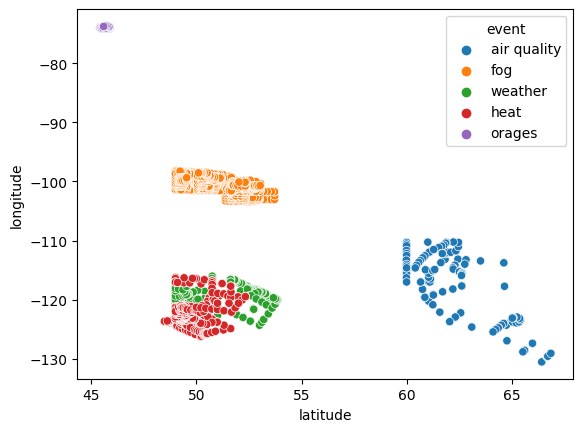

In [54]:
import seaborn as sns
sns.scatterplot(data=final_df,x='latitude',y='longitude',hue = 'event')

In [55]:
cities = pd.read_csv(r'C:\Users\srika\OneDrive\Documents\York\Sem-1 york\MMAI 5100 - database fundamentals\ca_geo_dimension.csv')
cities.sample(10)

,province,region,zipcode,latitude,longitude
713124,Alberta,Calgary,T3C2A2,51.041404,-114.149766
90844,New Brunswick,Kings,E5P3Z6,45.727306,-65.672073
421615,Ontario,York,L4C4W3,43.878212,-79.452232
41051,Nova Scotia,Colchester,B6L5J3,45.393260,-63.366409
672200,Saskatchewan,Saskatoon,S7J1Y1,52.103515,-106.636804
481362,Ontario,Hamilton,L8W2B5,43.205279,-79.852460
474304,Ontario,Hamilton,L8H7G1,43.281539,-79.785306
754745,Alberta,Edmonton,T6T0K8,53.462834,-113.369536
407472,Ontario,Niagara,L3C5X7,43.010643,-79.262633
823545,British Columbia,Greater Vancouver,V3W8L9,49.144293,-122.876149


In [56]:
cities['identifer']='city'
cities['event']='city'

In [68]:
cities.sample(20)

,province,region,zipcode,latitude,longitude,identifer,event
498210,Ontario,Toronto,M1J2K1,43.740832,-79.232153,city,city
751826,Alberta,Edmonton,T6K3C3,53.442331,-113.449012,city,city
75319,New Brunswick,Albert,E4H4Y5,45.926030,-64.640167,city,city
190196,Quebec,Montréal,H1N2G4,45.580850,-73.511973,city,city
202665,Quebec,Montréal,H2Y4A7,45.496557,-73.722793,city,city
336472,Ontario,Ottawa,K1G3J2,45.357252,-75.740516,city,city
228792,Quebec,Montréal,H8P1B4,45.423101,-73.618261,city,city
465034,Ontario,Halton,L7G5B6,43.642856,-79.905044,city,city
708493,Alberta,Calgary,T2X2Z2,50.904308,-114.025530,city,city
410675,Ontario,York,L3P4G3,43.890530,-79.245377,city,city


In [58]:
# Keep only desired columns
dt = cities[['latitude', 'longitude', 'identifer','event']]
dp = final_df[['latitude', 'longitude', 'identifer','event']]

# Concatenate dataframes
dg = pd.concat((dt, dp), axis=0)

In [59]:
dg

,latitude,longitude,identifer,event
0,47.582052,-53.279852,city,city
1,47.423351,-53.196602,city,city
2,47.385590,-53.134060,city,city
3,46.737209,-53.363831,city,city
4,47.536968,-53.269871,city,city
...,...,...,...,...
5315,45.833500,-73.821200,alert,orages
5316,45.757100,-73.712600,alert,orages
5317,45.697000,-73.767000,alert,orages
5318,45.643400,-73.706600,alert,orages


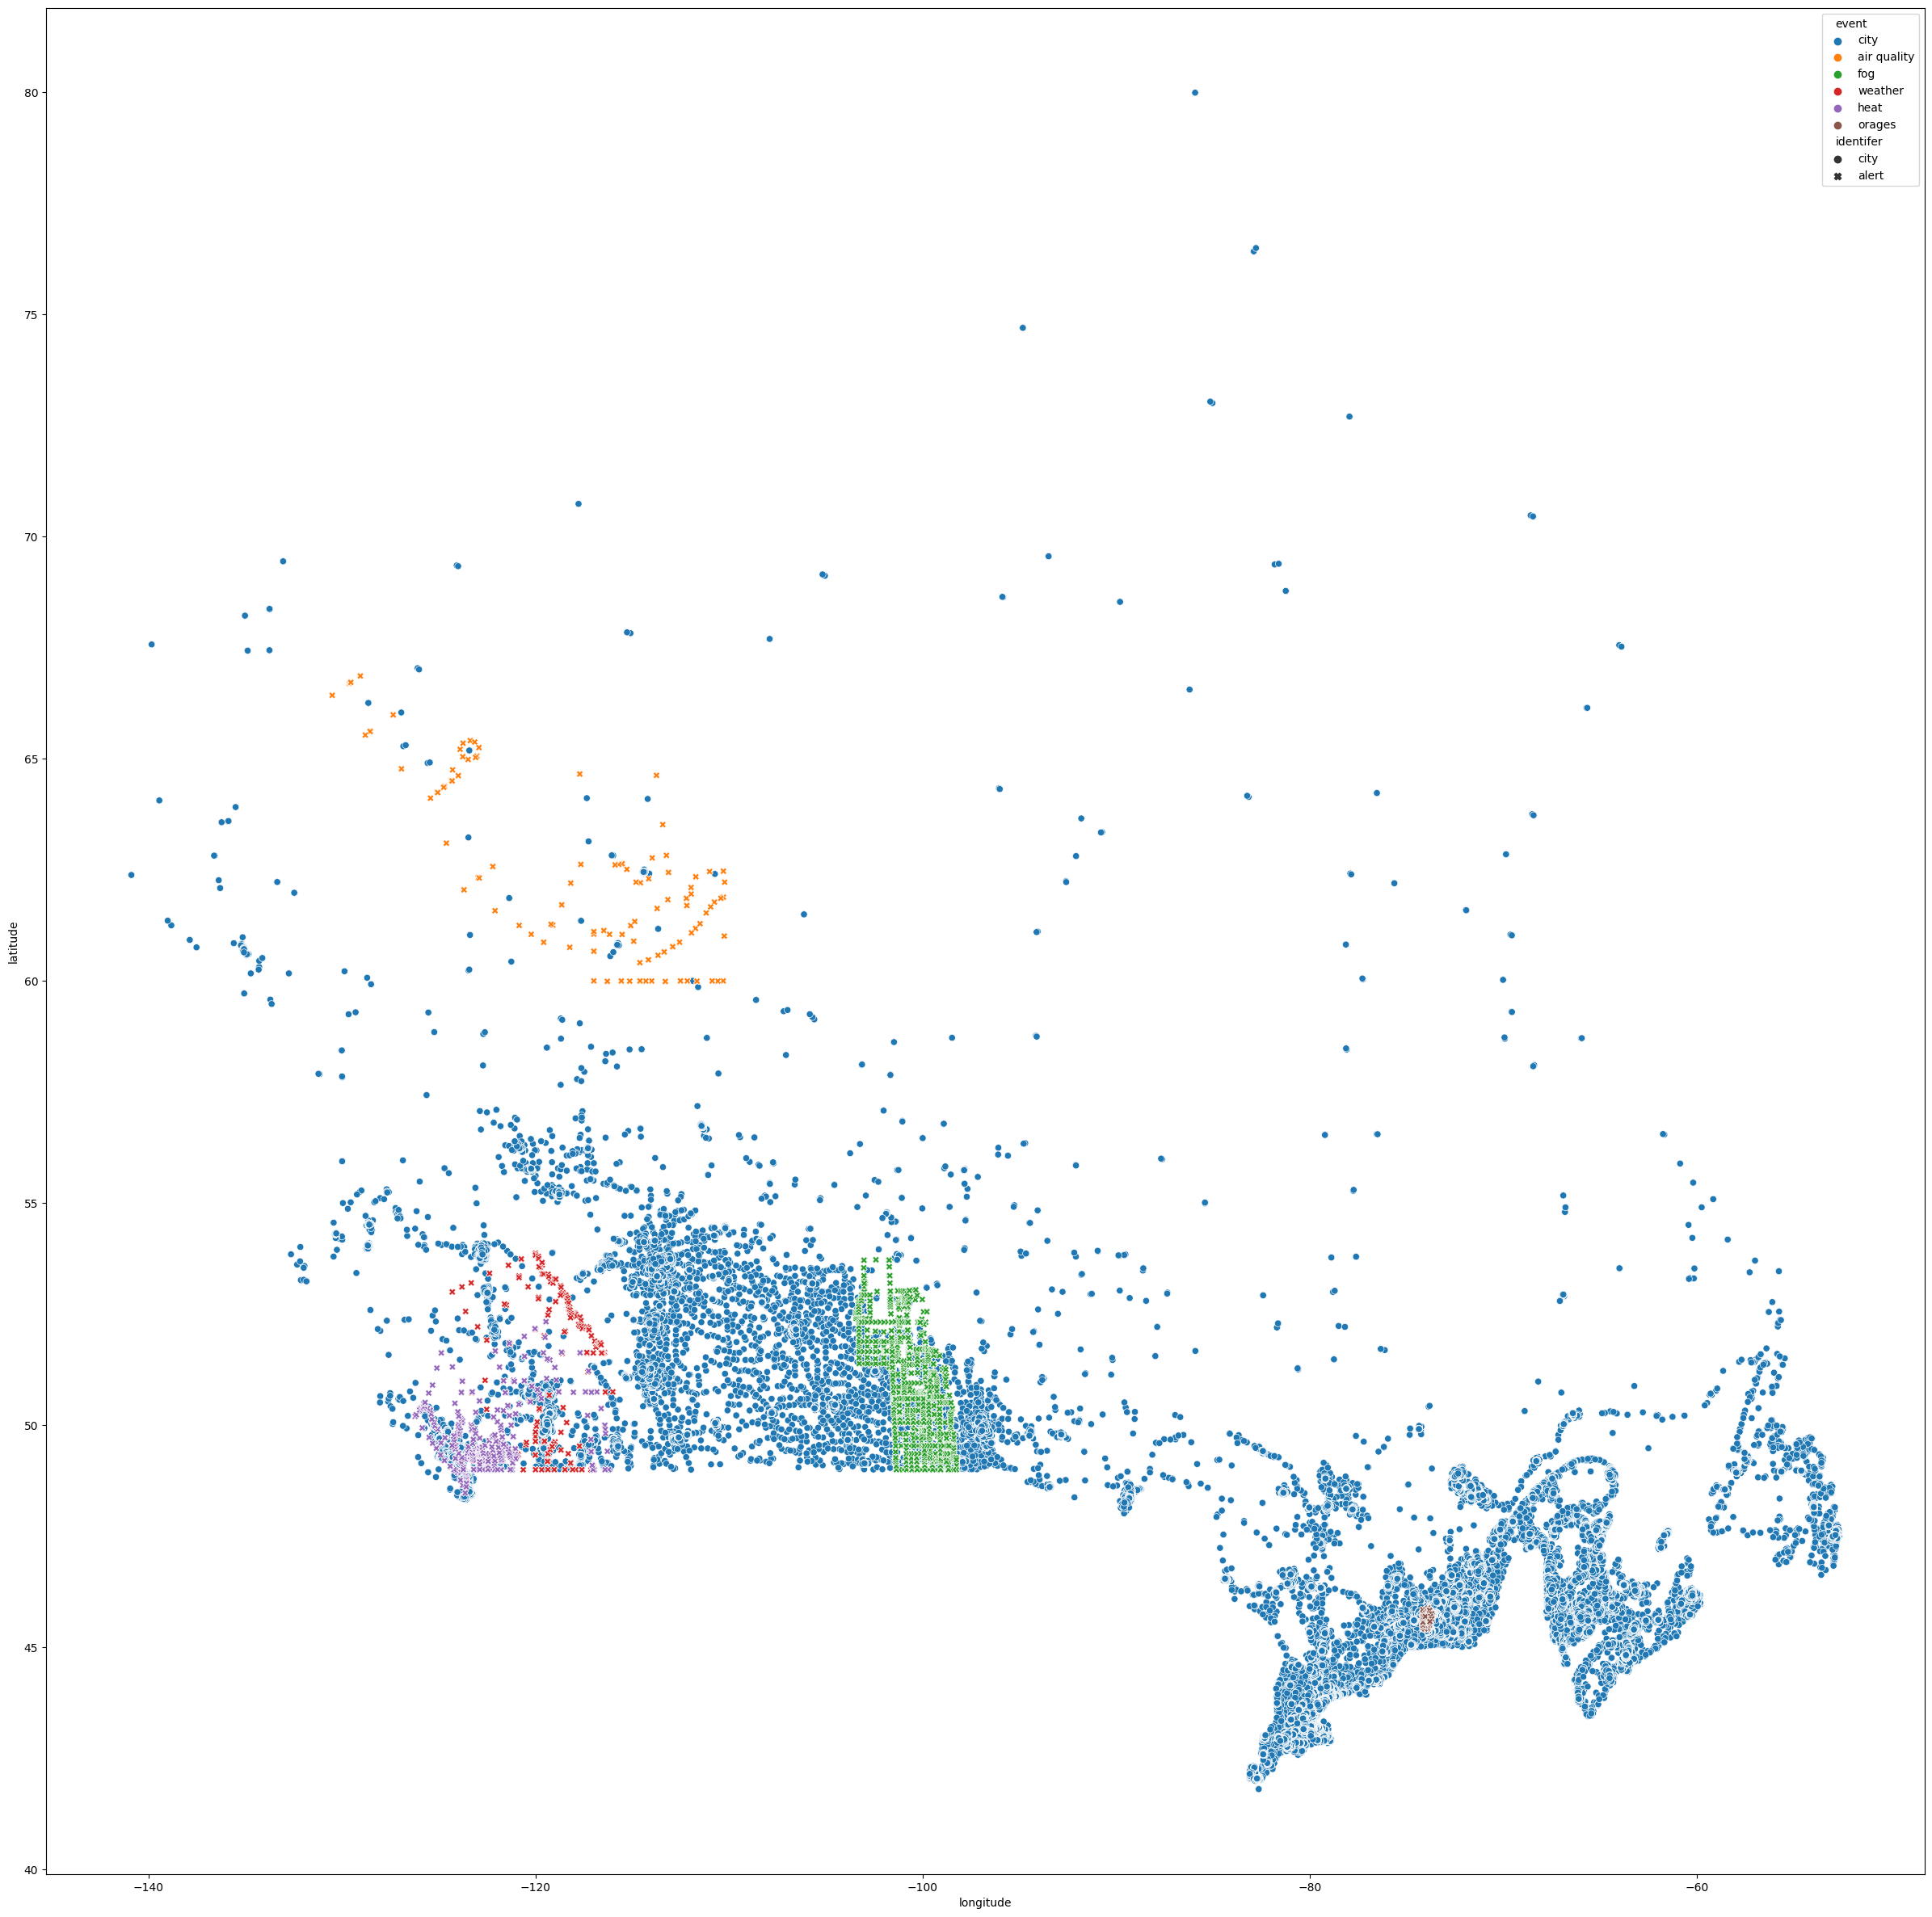

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
sns.scatterplot ( data = dg, x='longitude',y='latitude',style='identifer',hue='event')
plt.show()

In [61]:
final_df.duplicated().count()

5320

In [62]:
final_df.drop_duplicates()

,event,latitude,longitude,identifer
0,air quality,60.8692,-119.5784,alert
1,air quality,61.0481,-120.2217,alert
2,air quality,61.2474,-120.8441,alert
3,air quality,61.5799,-122.0903,alert
4,air quality,62.0492,-123.6944,alert
...,...,...,...,...
5252,orages,45.8535,-73.8439,alert
5254,orages,45.8188,-73.8058,alert
5255,orages,45.8104,-73.8078,alert
5256,orages,45.6693,-74.0313,alert


In [63]:
final_df.head(30)

,event,latitude,longitude,identifer
0,air quality,60.8692,-119.5784,alert
1,air quality,61.0481,-120.2217,alert
2,air quality,61.2474,-120.8441,alert
3,air quality,61.5799,-122.0903,alert
4,air quality,62.0492,-123.6944,alert
5,air quality,62.3249,-122.9583,alert
6,air quality,62.5730,-122.2057,alert
7,air quality,61.7115,-118.6464,alert
8,air quality,61.2559,-119.1044,alert
9,air quality,60.8692,-119.5784,alert


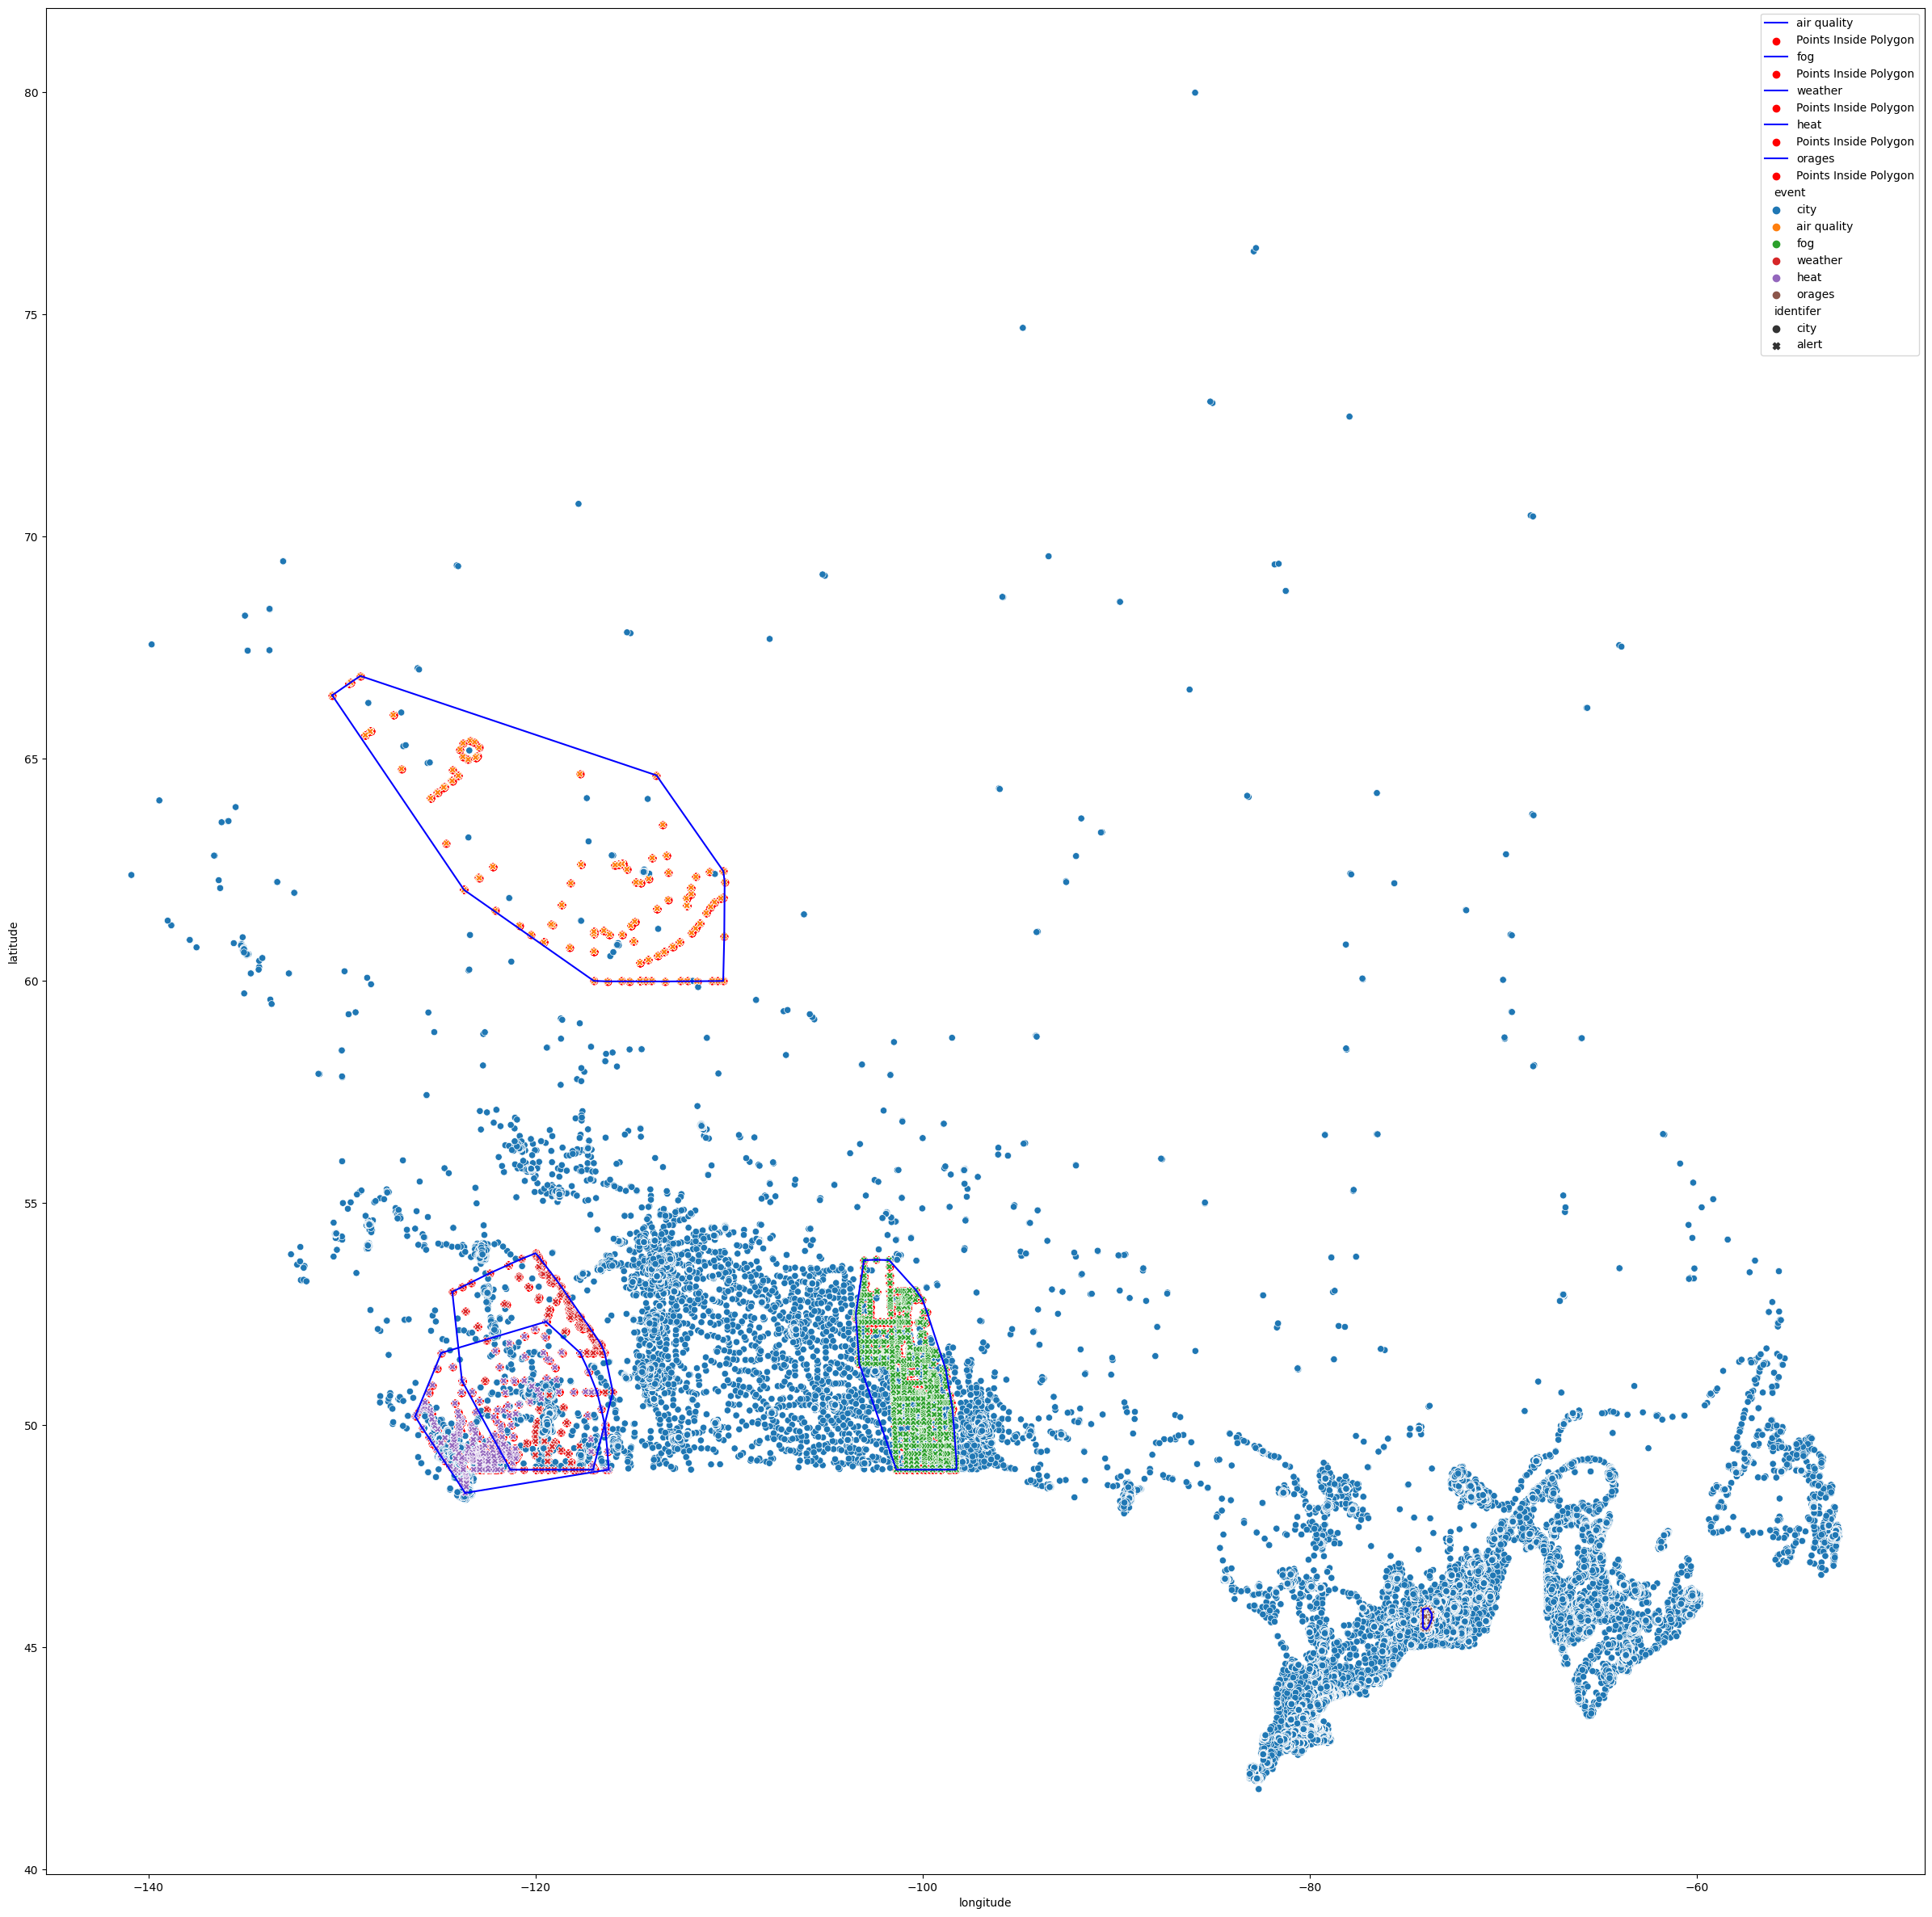

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
from scipy.spatial import ConvexHull
import math

# Assuming final_df is already defined and imported

# Get unique events
unique_events = final_df['event'].unique()

plt.figure(figsize=(30, 30))
# Iterate through each unique event
for event in unique_events:
    
    
    
    # Filter data for the current event
    event_data = final_df[final_df['event'] == event]
    
    coords = list(zip(event_data['longitude'], event_data['latitude']))
    
    # Calculate the convex hull
    hull = ConvexHull(coords)
    hull_vertices = hull.vertices.tolist()
    
    hull_coords = [coords[i] for i in hull_vertices]
    
    polygon = Polygon(hull_coords)
    
    plt.plot(*polygon.exterior.xy, label=event, color='blue')
    plt.scatter(event_data['longitude'], event_data['latitude'], color='red', label='Points Inside Polygon')


sns.scatterplot ( data = dg, x='longitude',y='latitude',style='identifer',hue='event')
plt.show()


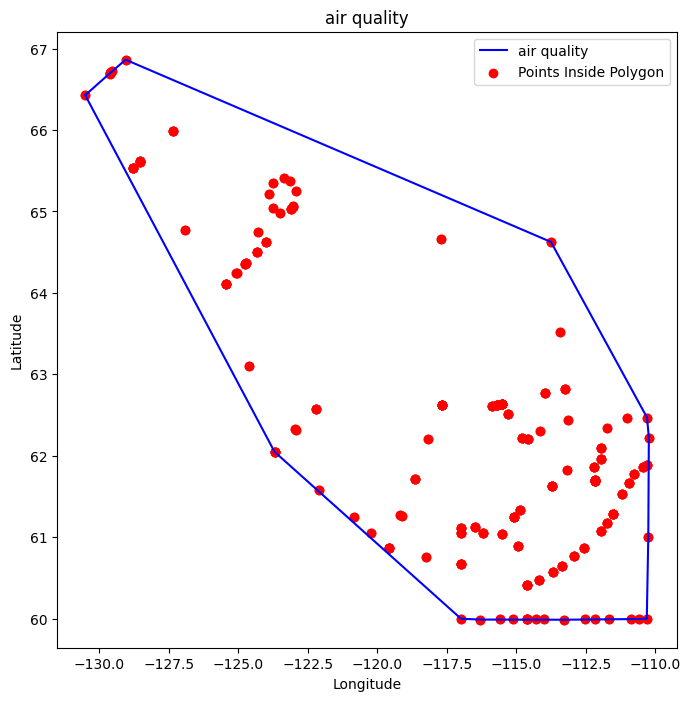

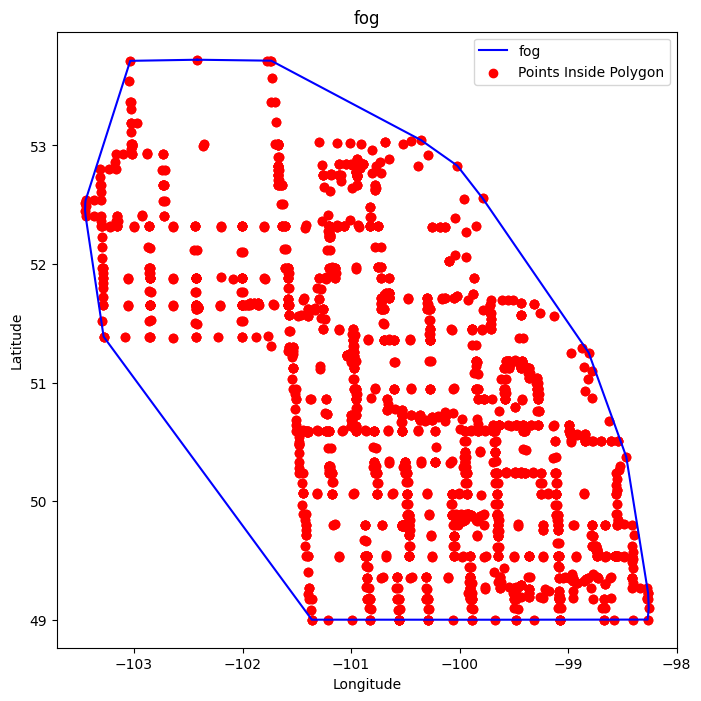

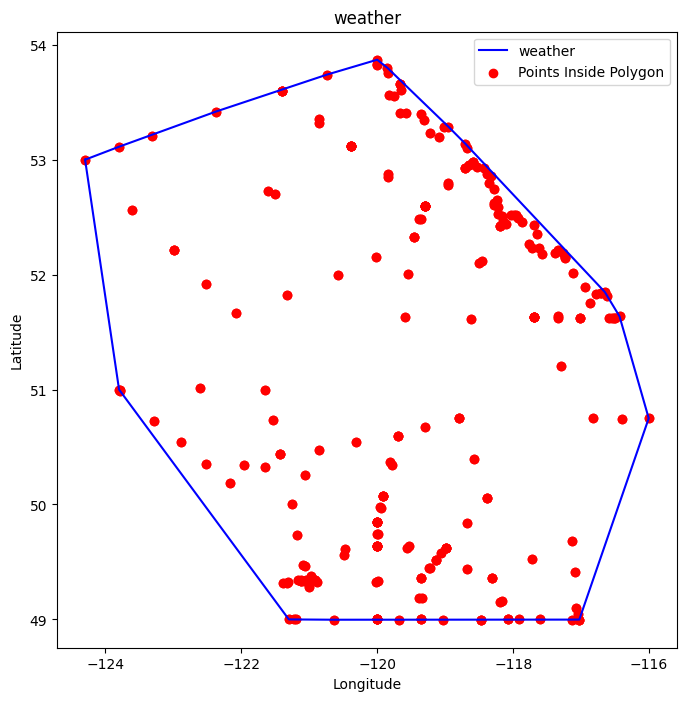

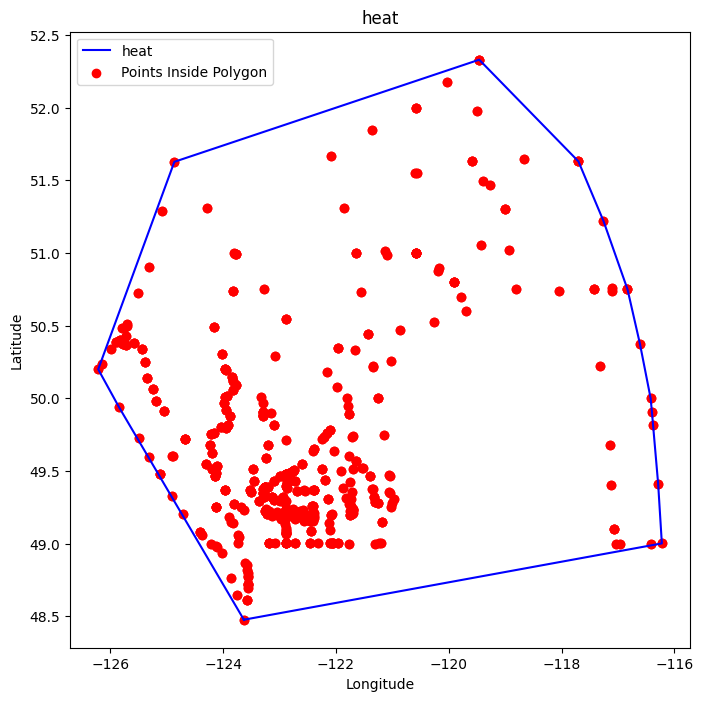

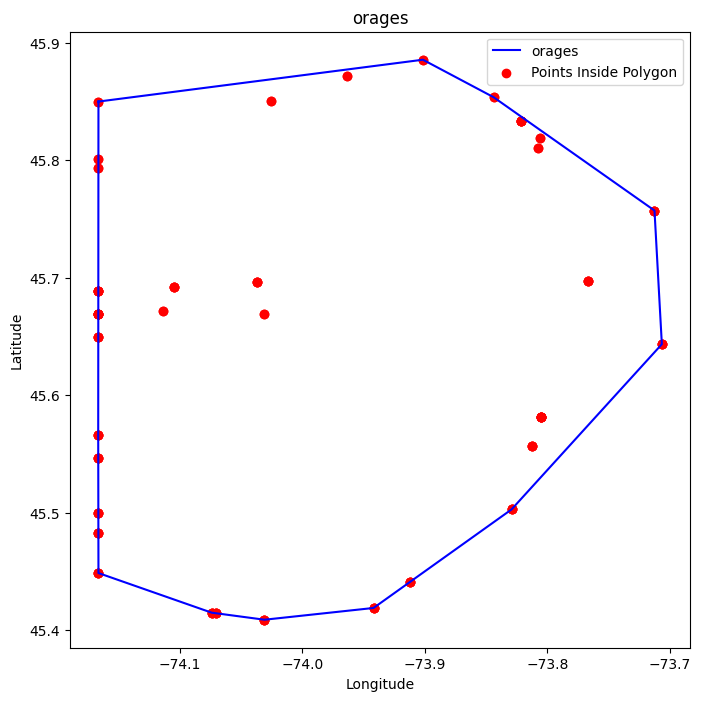

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
from scipy.spatial import ConvexHull
import math

# Assuming final_df is already defined and imported

# Get unique events
unique_events = final_df['event'].unique()

# Iterate through each unique event
for event in unique_events:
    plt.figure(figsize=(8, 8))
    plt.title(event)
    
    # Filter data for the current event
    event_data = final_df[final_df['event'] == event]
    
    coords = list(zip(event_data['longitude'], event_data['latitude']))
    
    # Calculate the convex hull
    hull = ConvexHull(coords)
    hull_vertices = hull.vertices.tolist()
    
    hull_coords = [coords[i] for i in hull_vertices]
    
    polygon = Polygon(hull_coords)
    
    plt.plot(*polygon.exterior.xy, label=event, color='blue')
    plt.scatter(event_data['longitude'], event_data['latitude'], color='red', label='Points Inside Polygon')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()


C:\Users\srika\AppData\Local\Temp\ipykernel_7260\1165076391.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities_inside_polygon['event'] = event


<Axes: xlabel='longitude', ylabel='latitude'>

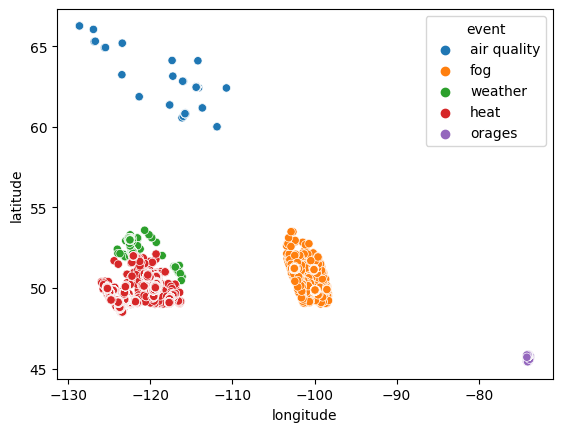

In [75]:
import pandas as pd
from shapely.geometry import Polygon
from scipy.spatial import ConvexHull


# Assuming final_df is already defined and imported

# Get unique events
unique_events = final_df['event'].unique()

# Initialize a list to store DataFrames for each event
event_data_frames = []

# Iterate through each unique event
for event in unique_events:
    event_data = final_df[final_df['event'] == event]
    coords = list(zip(event_data['longitude'], event_data['latitude']))
    
    # Calculate the convex hull
    hull = ConvexHull(coords)
    hull_vertices = hull.vertices.tolist()
    
    hull_coords = [coords[i] for i in hull_vertices]
    
    polygon = Polygon(hull_coords)
    
    # Filter cities inside the polygon
    cities_inside_polygon = cities[cities.apply(lambda row: polygon.contains(Point(row['longitude'], row['latitude'])), axis=1)]
    
    # Add event column to the filtered cities
    cities_inside_polygon['event'] = event
    
    # Append to the list of DataFrames
    event_data_frames.append(cities_inside_polygon)

# Concatenate all event DataFrames into a single DataFrame
city_event_data = pd.concat(event_data_frames, ignore_index=True)


city_event_data.shape
sns.scatterplot(data=city_event_data, x='longitude',y='latitude',hue='event')

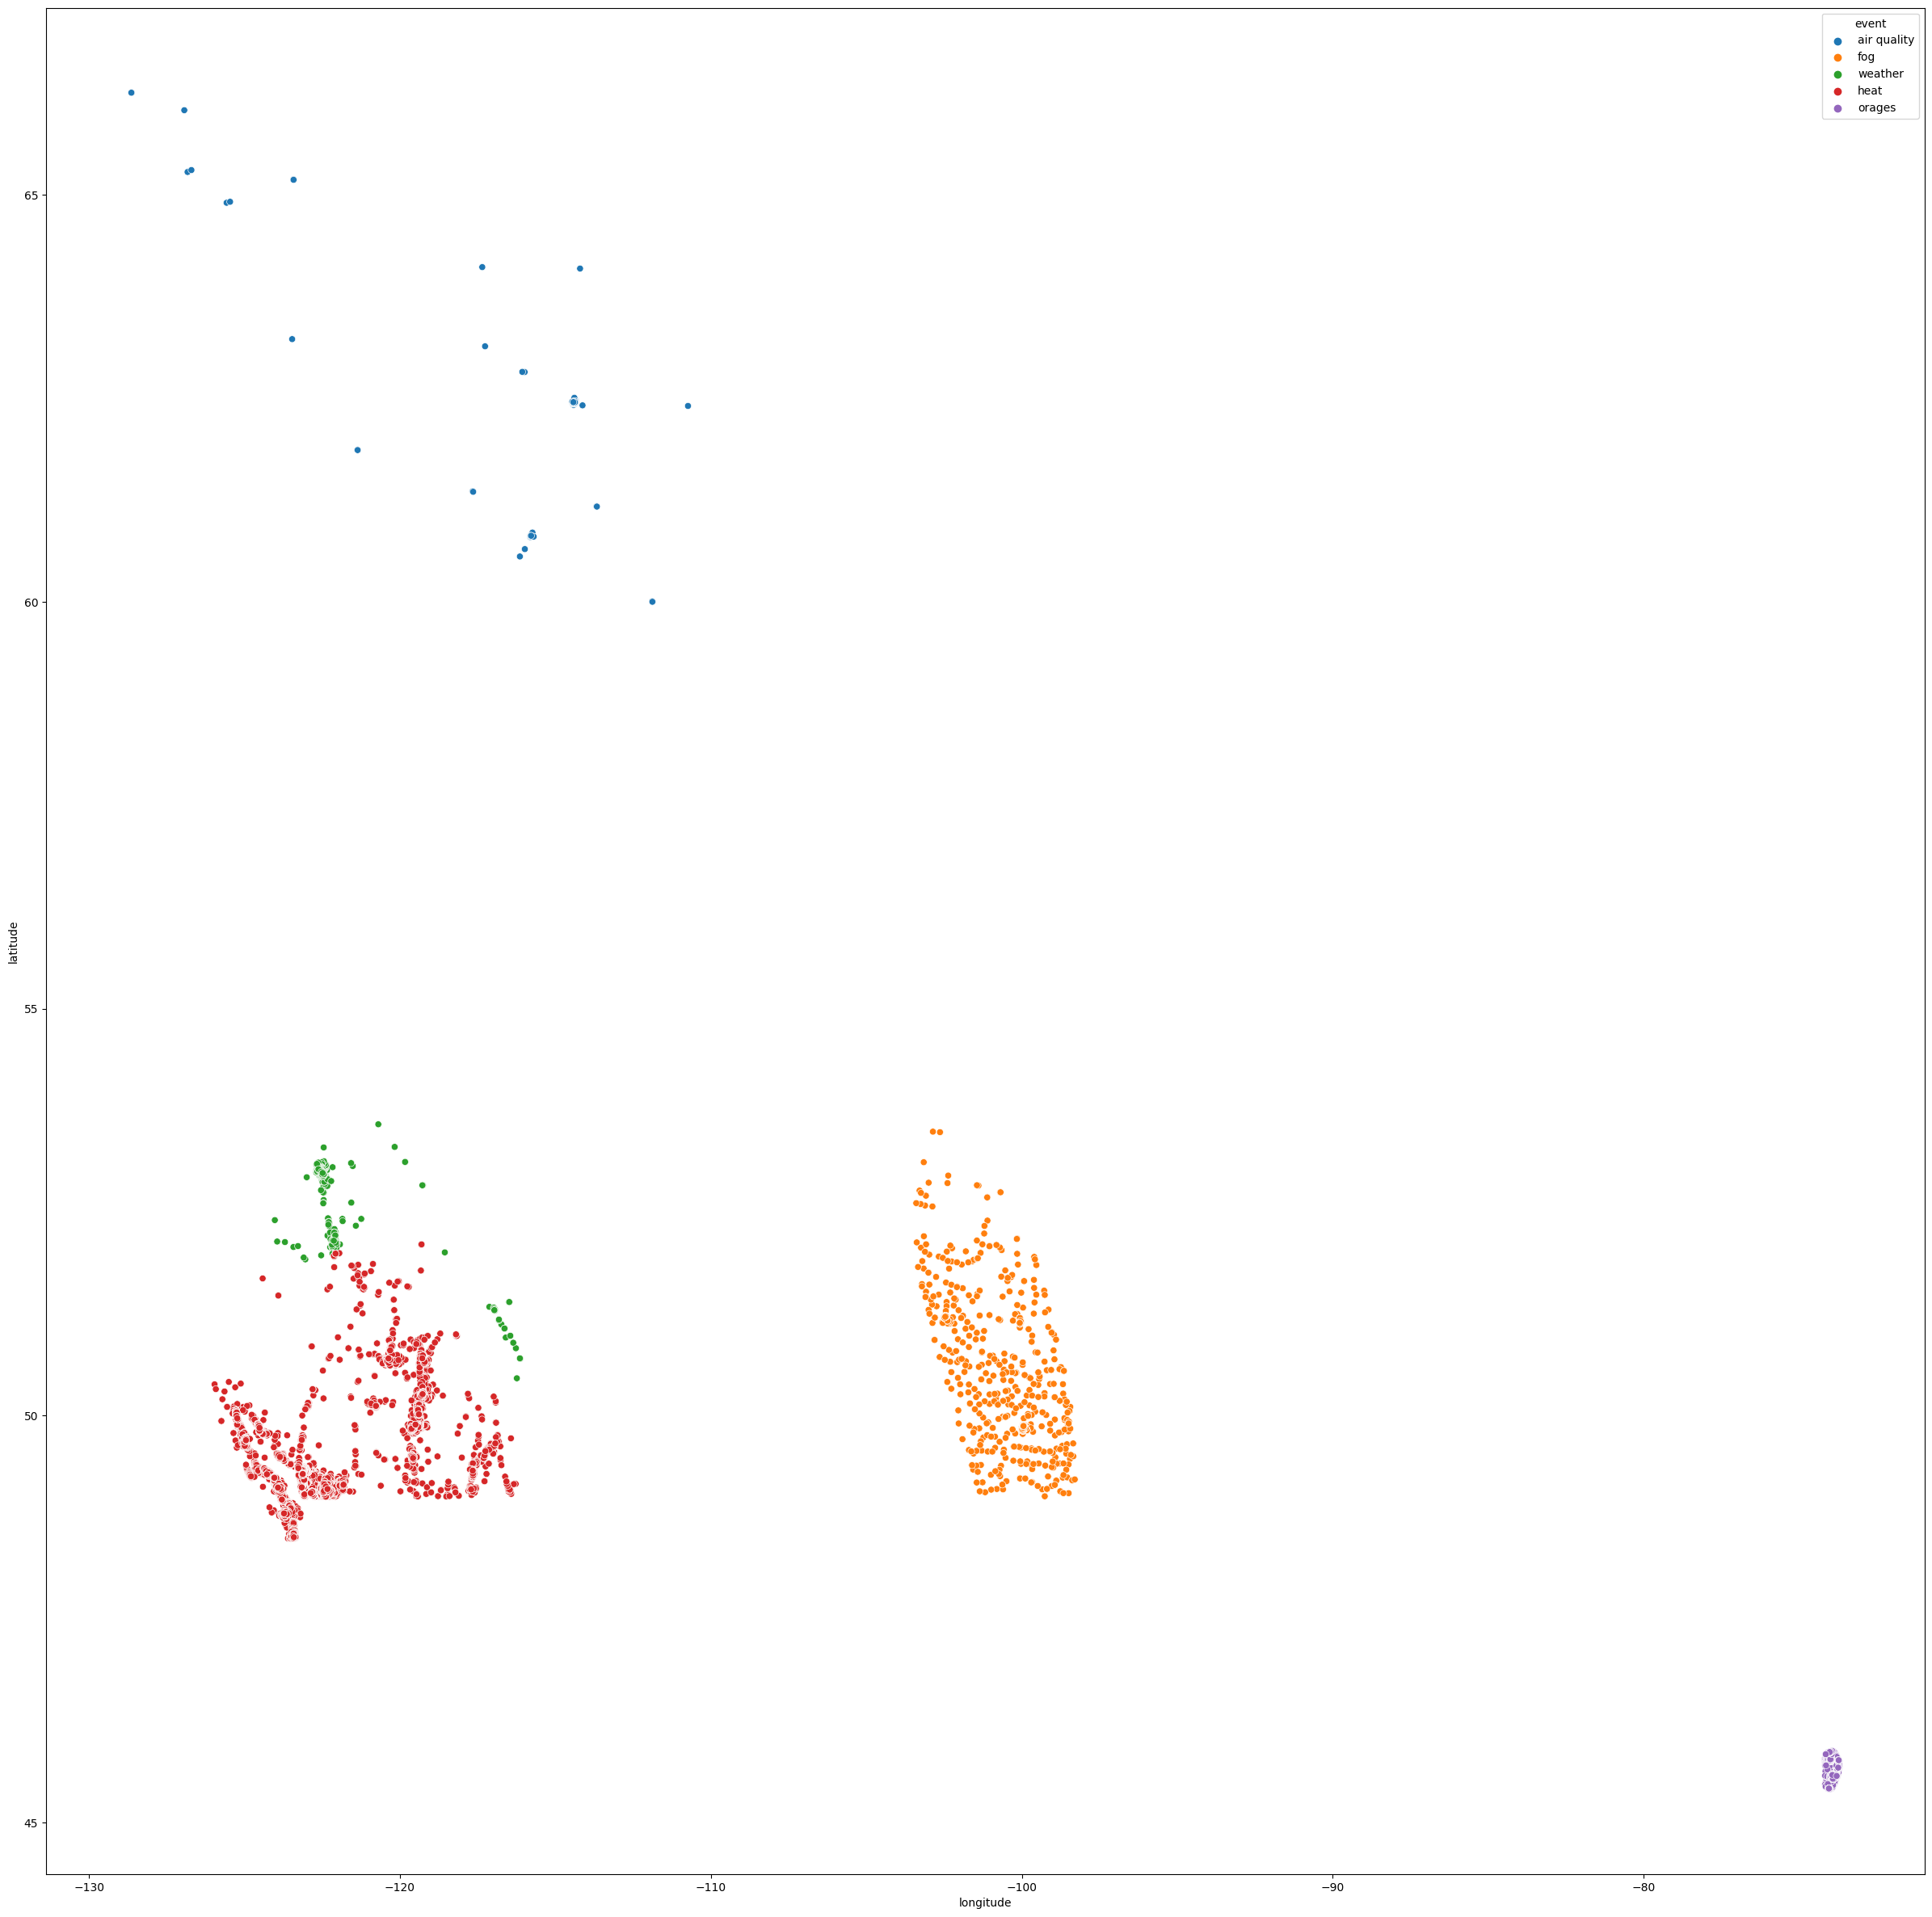

In [79]:
plt.figure(figsize=(30, 30))
sns.scatterplot ( data = city_event_data, x='longitude',y='latitude',hue='event')
plt.show()

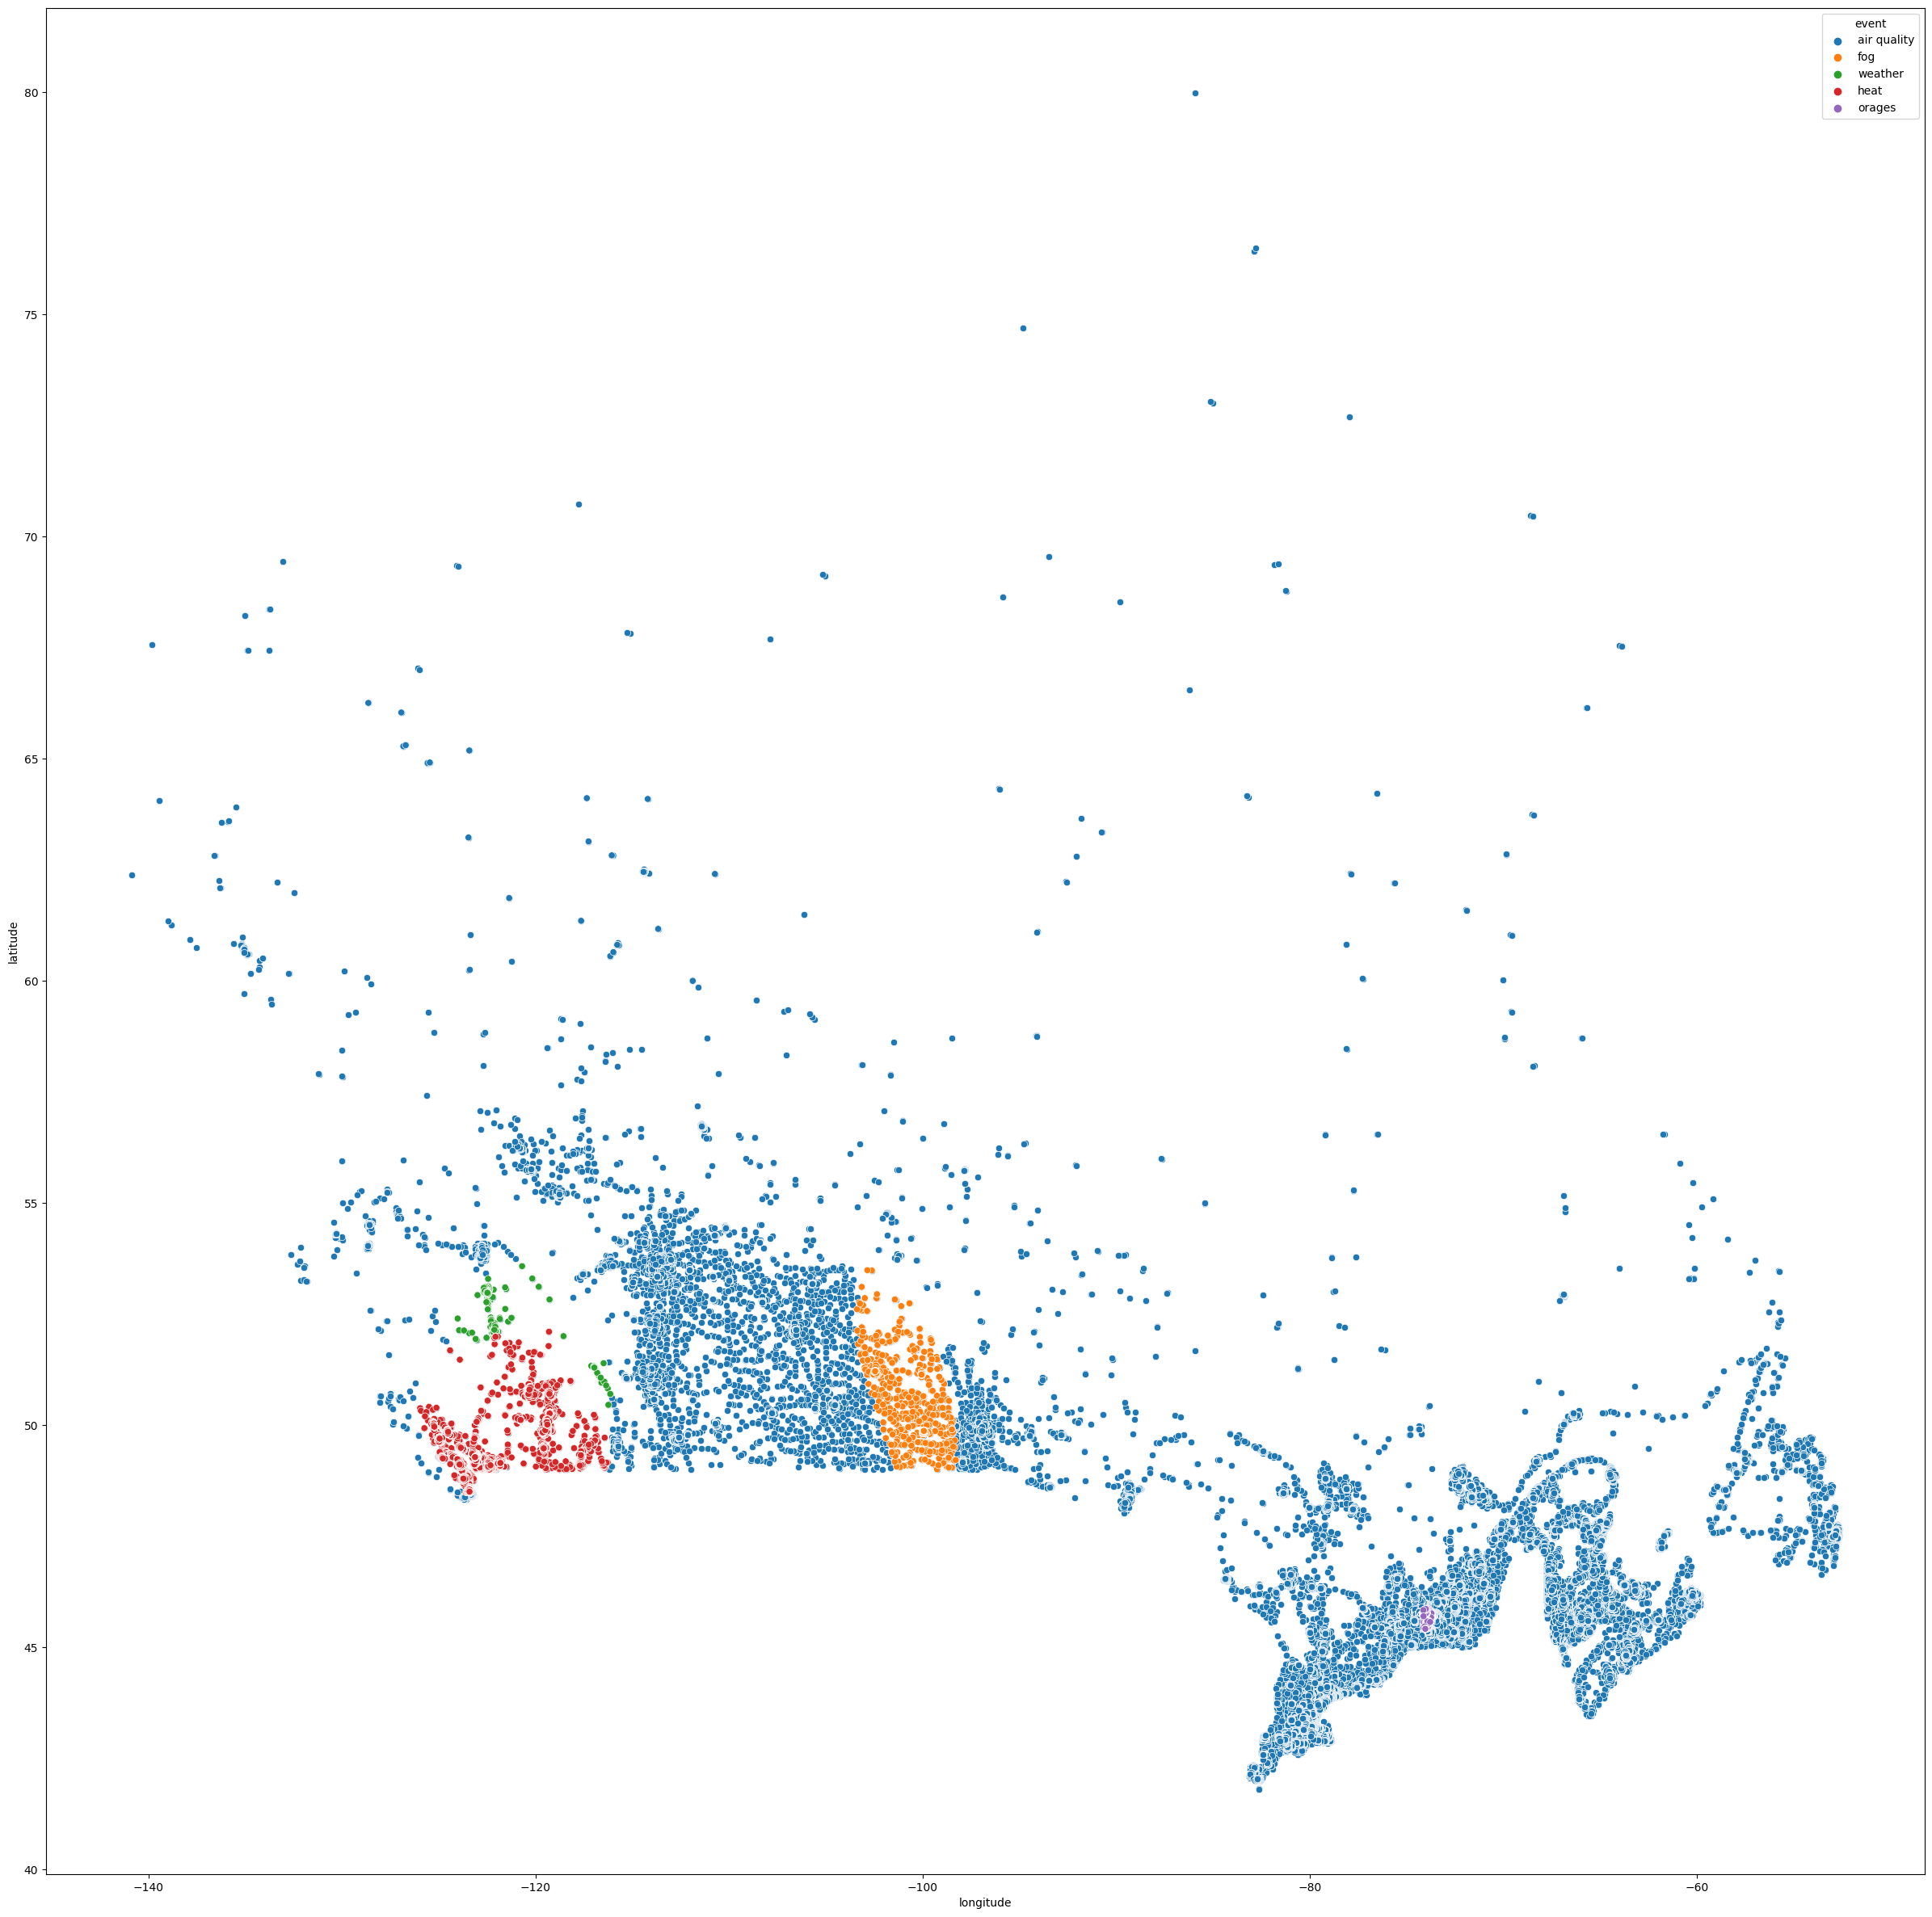

In [80]:
plt.figure(figsize=(30, 30))
sns.scatterplot ( data = cities, x='longitude',y='latitude')
sns.scatterplot ( data = city_event_data, x='longitude',y='latitude',hue='event')
plt.show()